In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

import random
import copy
import time

import gym

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.pylabtools import figsize

In [2]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def append(self, elem):
        if len(self.memory) < self.capacity:
            self.memory.append(elem)
        self.memory[self.position] = elem
        self.position = (self.position + 1) % self.capacity
            
    def get_minibatch(self, size):
        return random.sample(self.memory, size)
    
    
    def __len__(self):
        return len(self.memory)

In [3]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        
        self.lin1 = nn.Linear(state_size, 400)
        self.lin2 = nn.Linear(400, 300)
        self.lin3 = nn.Linear(300, action_size)
        
    def forward(self, state):
        x = F.relu(self.lin1(state))
        x = F.relu(self.lin2(x))
        x = torch.tanh(self.lin3(x)) * self.max_action
        return x

In [4]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        
        self.lin1 = nn.Linear(state_size + action_size, 400)
        self.lin2 = nn.Linear(400, 300)
        self.lin3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [5]:
def plot_reward(reward, max_episode, step):
    plt.xlim(-10, max_episode // step)
    plt.ylim(-300, 300)
    plt.plot(reward)
    plt.grid()
    plt.show()
    clear_output(wait=True)
    time.sleep(1)

In [6]:
class OrnsteinUhlenbeckActionNoise:

    def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.X = np.ones(self.action_dim) * self.mu

    def reset(self):
        self.X = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.X)
        dx = dx + self.sigma * np.random.randn(len(self.X))
        self.X = self.X + dx
        return self.X

In [7]:
class TD3:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.shape[0]
        self.max_action = 1
        
        self.actor_lr  = 1e-3
        self.critic_lr = 1e-3
        self.batch_size = 100
        
        self.gamma = 0.99
        self.tau = 1e-3
        
        self.policy_noise = 0.6
        self.noise_clip = 0.7
        self.policy_delay = 0.1
        self.exploration_noise = 0.1
        
        self.max_episode = 700
        self.max_step = 1000
        self.exploit_episode = 10
        self.target_update_step = 2
        
        self.memory_size = 1000000
        
        self.noise = OrnsteinUhlenbeckActionNoise(self.action_size)
        self.memory = Memory(self.memory_size)
        self.device = torch.device('cuda')
        
        self.actor = Actor(self.state_size, self.action_size, self.max_action).to(self.device)
        self.target_actor = copy.deepcopy(self.actor).to(self.device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        
        self.critic1 = Critic(self.state_size, self.action_size).to(self.device)
        self.target_critic1 = copy.deepcopy(self.critic1).to(self.device)
        self.critic_optim1 = optim.Adam(self.critic1.parameters(), lr=self.critic_lr)
        
        self.critic2 = Critic(self.state_size, self.action_size).to(self.device)
        self.target_critic2 = copy.deepcopy(self.critic2).to(self.device)
        self.critic_optim2 = optim.Adam(self.critic2.parameters(), lr=self.critic_lr)
        
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state).detach().cpu().numpy().flatten()
        return action
    
    def soft_update(self, model, target_model):
        for param, target_param in zip(model.parameters(), target_model.parameters()):
            target_param.data.copy_(((1 - self.tau) * target_param.data) + self.tau * param.data)
    
    def optimize(self, batch):
        state, action, reward, next_state, is_terminal = batch
        
        state = torch.tensor(state).to(self.device).float()
        action = torch.tensor(action).to(self.device).float()
        reward = torch.tensor(reward).unsqueeze(1).to(self.device).float()
        next_state = torch.tensor(next_state).to(self.device).float()
        is_terminal = torch.tensor(is_terminal).unsqueeze(1).to(self.device).float()

        with torch.no_grad():
            noise = torch.randn_like(action) * self.policy_noise
            noise = noise.clamp(-self.noise_clip, self.noise_clip)

            next_action = self.target_actor(next_state) + noise
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            target_q1 = self.target_critic1(next_state, next_action)
            target_q2 = self.target_critic2(next_state, next_action)
        
            target_q = torch.min(target_q1, target_q2)
            target_q = reward + (1 - is_terminal) * self.gamma * target_q
            
        q1 = self.critic1(state, action)
        
        critic_loss1 = F.mse_loss(q1, target_q)
        self.critic_optim1.zero_grad()
        critic_loss1.backward()
        self.critic_optim1.step()
        
        q2 = self.critic2(state, action)

        critic_loss2 = F.mse_loss(q2, target_q)
        self.critic_optim2.zero_grad()
        critic_loss2.backward()
        self.critic_optim2.step()
        
        if self.total_step % self.target_update_step == 0:
            actor_loss = - self.critic1(state, self.actor(state)).mean()
            
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()
            
            self.soft_update(self.actor, self.target_actor)
            self.soft_update(self.critic1, self.target_critic1)
            self.soft_update(self.critic2, self.target_critic2)
    
    def exploit(self, render=True):
        state = self.env.reset()
        r = 0.
        is_terminal = False
        
        while not is_terminal:
            if render:
                self.env.render()
            action = self.select_action(state)
            state, reward, is_terminal, _ = self.env.step(action)
            r += reward
        return r
    
    
    def train(self):
        self.total_step = 0
        explorer_reward = []
        exploit_reward = []
        for episode in range(1, self.max_episode+1):
            state = self.env.reset()
            cur_r = 0
            for t in range(1, self.max_step+1):
                self.total_step += 1

                action = self.select_action(state)
                action += self.noise.sample()
                #action += np.random.normal(0, self.exploration_noise, size=self.action_size)
                #action = action.clip(-self.max_action, self.max_action)

                next_state, reward, is_terminal, _ = self.env.step(action)
                cur_r += reward

                self.memory.append((state, action, reward, next_state, is_terminal))

                state = next_state

                if self.total_step > self.batch_size:
                    self.optimize(list(zip(*self.memory.get_minibatch(self.batch_size))))

                if is_terminal:
                    explorer_reward.append(cur_r)
                    break
            plot_reward(explorer_reward, self.max_episode, 1)

            if episode % self.exploit_episode == 0:
                r = self.exploit(render=False)
                exploit_reward.append(r)
                print(r)
#                 plot_reward(exploit_reward, self.max_episode, self.exploit_episode)

        return explorer_reward, exploit_reward

In [8]:
agent = TD3('BipedalWalker-v2')

In [10]:
explorer_reward, exploit_reward = agent.train()

249.75167250893924


------------
Exploration reward:

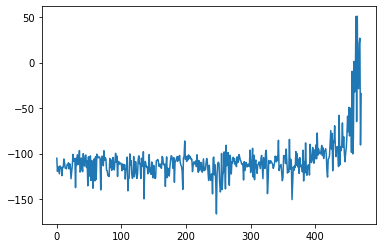

In [12]:
plt.plot(explorer_reward)

Exploitation reward:

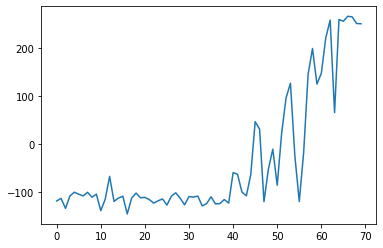

In [13]:
plt.plot(exploit_reward)

In [31]:
test_reward = []
n_steps = 100
for i in range(1, n_steps+1):
    r = agent.exploit(render=False)
    test_reward.append(r)
    
print('avg reward: {}'.format(sum(test_reward)/(n_steps+1)))

avg reward: 248.4762361993298
